In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
pd.set_option('display.max_columns', None)

## Reading the files and preparing them for machine learning

In [3]:
accepted2007 = pd.read_csv("accepted_2007_2011.csv")

In [4]:
accepted2016 = pd.read_csv("accepted_2016_2018_individual.csv")

In [ ]:
accepted2007.set_index("id", inplace=True)

In [ ]:
accepted2016.set_index("id", inplace=True)

In [ ]:
drop_no_var2007 = ["hardship_flag", "disbursement_method", "tax_liens", "delinq_amnt", "chargeoff_within_12_mths", "acc_now_delinq", "application_type", 
"policy_code", "collections_12_mths_ex_med", "out_prncp", "out_prncp_inv", "pub_rec", "desc", "loan_status", "initial_list_status"]

In [ ]:
drop_no_var2016 = ["hardship_flag", "chargeoff_within_12_mths", "application_type", "policy_code", "out_prncp",
               "pymnt_plan"]

In [ ]:
post_loan_list2007 = ["total_pymnt", "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
                  "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "last_credit_pull_d", 
                  "last_fico_range_high", "last_fico_range_low", "debt_settlement_flag", "installment"]

In [ ]:
post_loan_list2016 = ["loan_status", "total_pymnt", "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
                  "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "last_credit_pull_d", 
                  "last_fico_range_high", "last_fico_range_low", "debt_settlement_flag", "installment", 
                  "disbursement_method", "hardship_flag"]

In [ ]:
drop_list_obj = ["sub_grade", "emp_title", "title", "addr_state", "earliest_cr_line", 
                 "issue_d", "desc"]

In [ ]:
accepted2007.drop((drop_no_var2007 + post_loan_list2007 + drop_list_obj), axis = 1, inplace=True)

In [ ]:
accepted2016.drop((drop_no_var2007 + post_loan_list2007 + drop_list_obj), axis = 1, inplace=True)

# Decission tree

I will use decission tree for the prediction of the loan grade. I will train separate models for the periods of 2007-2011 and 2016-2018 as the latter period has more features availbale so might result in a more accurate model

## 2007-2011

In [ ]:
accepted2007.shape

(39997, 22)

### Cross-validation

First I will cross-validate my dataset to make sure that the score of my model is not random. I will iterate over max_depth hyperparameter to see at which point the mean score stops being affected. I will use 20 folds for higher confidence 

In [ ]:
from sklearn.model_selection import cross_val_score
accepted2007_grade = accepted2007["grade"]
accepted2007_features = accepted2007.drop("grade", axis = 1)
accepted2007_features = pd.get_dummies(accepted2007_features)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
cv = cross_val_score(DecisionTreeClassifier(),accepted2007_features, accepted2007_grade, cv=20)

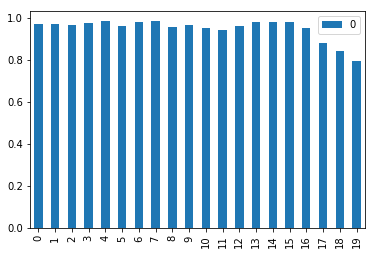

In [ ]:
pd.DataFrame(cv).plot(kind="bar")

Results of cross-validations seem to stay fairly stable throughout itterations

In [ ]:
np.mean(cv)

0.9510864225064873

In [ ]:
accuracy = []
for i in range(1,40):
    cv = cross_val_score(DecisionTreeClassifier(max_depth = i),accepted2007_features, accepted2007_grade, cv=20)
    accuracy.append(np.mean(cv))

In [ ]:
pd.DataFrame(accuracy).plot()

After iterating over various depths of decission tree it looks that from around the depth of 10 the decidion tree stops impoving, therefore I will use this hyperparameter for further testing.

### Decission tree train

After seing that the model is fairly stable I will split my dataset into train/set and train it again so I can check more success measures using the max_depth of 10 

In [ ]:
from sklearn.model_selection import train_test_split

#sub_grade = accepted["sub_grade"]
loans_train, loans_test, grade_train, grade_test = train_test_split(accepted2007_features, accepted2007_grade, 
                                                                    test_size=0.2, random_state=42)

In [ ]:
grade_class = DecisionTreeClassifier(max_depth = 10, random_state=0)

In [ ]:
grade_class.fit(loans_train, grade_train)

In [ ]:
grade_class.score(loans_test, grade_test)

The score of the model seems to be fairly high and is inline with cross-validation results. Next i will make a confuccion matrix to see precission, recall and f-1 score of my model

### Confussion matrix

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
y_pred = grade_class.predict(loans_test)

In [ ]:
confusion_matrix(grade_test,y_pred)

In [ ]:
print(classification_report(grade_test,y_pred))

The results seem to be lower for lower grade loans due to the fact that they are under represented in the dataset. This could be impoved by using oversampling

In [ ]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(grade_class, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

## 2016-2018

### Cross Validation

In [49]:
accepted2016_grade = accepted2016["grade"]
accepted2016_features = accepted2016.drop("grade", axis = 1)
accepted2016_features = pd.get_dummies(accepted2016_features)

In [ ]:
cv = cross_val_score(DecisionTreeClassifier(),accepted2016_features, accepted2016_grade, cv=20)

In [ ]:
pd.DataFrame(cv).plot(kind="bar")

In [ ]:
np.mean(cv)

In [ ]:
accuracy = []
for i in range(1,20):
    cv = cross_val_score(DecisionTreeClassifier(max_depth = i),accepted2016_features, accepted2016_grade, cv=10)
    accuracy.append(np.mean(cv))

In [ ]:
pd.DataFrame(accuracy).plot()

### Decission tree train

In [ ]:
from sklearn.model_selection import train_test_split

loans_train, loans_test, grade_train, grade_test = train_test_split(accepted2016_features,
                                                                    accepted2016_grade, test_size=0.2, random_state=42)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
grade_class = DecisionTreeClassifier(max_depth = 5, random_state=0)

In [ ]:
grade_class.fit(loans_train, grade_train)

In [ ]:
grade_class.score(loans_test, grade_test)

In [ ]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(grade_class, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### Confusion matrix

In [36]:
from sklearn.metrics import confusion_matrix, classification_report

In [37]:
y_pred = grade_class.predict(loans_test)

In [38]:
confusion_matrix(grade_test,y_pred)

array([[38033,     0,     3,     0,     0,     1,     0],
       [    0, 56457,  1147,     3,     1,     0,     0],
       [    3,  1146, 56430,     6,     1,     0,     0],
       [    0,     0,     6, 25867,   459,     1,     0],
       [    0,     1,     3,   425,  8961,   115,     0],
       [    1,     0,     0,     0,   124,  2686,    33],
       [    0,     0,     2,     0,     0,    20,   970]])

In [39]:
print(classification_report(grade_test,y_pred))

              precision    recall  f1-score   support

           A       1.00      1.00      1.00     38037
           B       0.98      0.98      0.98     57608
           C       0.98      0.98      0.98     57586
           D       0.98      0.98      0.98     26333
           E       0.94      0.94      0.94      9505
           F       0.95      0.94      0.95      2844
           G       0.97      0.98      0.97       992

   micro avg       0.98      0.98      0.98    192905
   macro avg       0.97      0.97      0.97    192905
weighted avg       0.98      0.98      0.98    192905



# Random forest

## 2007-2011

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [41]:
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
clf.fit(loans_train, grade_train)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini', 
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
                       oob_score=False, random_state=0, verbose=0, warm_start=False)
print(clf.feature_importances_)


[2.57657465e-03 2.41849224e-03 2.60897912e-03 7.20564634e-01
 2.75714449e-03 6.76302496e-03 4.54459471e-04 4.41252123e-02
 3.51419199e-02 1.78332022e-03 1.88024794e-04 1.04480339e-03
 5.74907172e-03 4.84000667e-04 5.47363213e-04 1.67011355e-03
 9.13177479e-04 1.21221589e-04 1.63222646e-03 8.60935835e-04
 1.97729291e-03 2.85735067e-04 1.56498580e-03 1.03745229e-03
 1.94458196e-03 1.13544369e-03 1.04321772e-02 5.86166535e-03
 3.05663463e-04 8.92609014e-05 1.19961740e-03 3.05114857e-03
 1.48427699e-03 1.86376557e-02 8.38058267e-03 6.13454796e-04
 1.20646826e-03 5.54466142e-04 5.84526690e-04 1.52578191e-03
 7.33611116e-04 9.26548350e-04 2.97246272e-04 2.50958824e-04
 2.63794622e-04 2.69535386e-04 2.93401853e-04 2.29417812e-04
 1.70572163e-04 3.02323398e-04 4.19033253e-04 1.51937694e-04
 5.66668878e-06 3.29953609e-05 3.27584650e-03 1.35505322e-03
 8.66003138e-03 1.41684667e-04 2.87051551e-03 3.37419031e-04
 1.08123875e-02 2.82818856e-04 3.06111760e-02 2.74580257e-02
 1.09984807e-05 1.760324

In [42]:
clf.score(loans_test, grade_test)

0.8340271117907778